In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Colab\ Notebooks

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [2]:
!pip install statsmodels==0.13.0
!pip install pmdarima

     |████████████████████████████████| 9.8 MB 5.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 1.4 MB 5.2 MB/s 


In [3]:
import numpy as np
import pandas as pd

from matplotlib import rcParams
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import missingno

import scipy as sp

# TIME SERIES
from statsmodels.tsa.arima.model import ARIMA # v 0.13.0
#from statsmodels.tsa.arima_model import ARIMA #v 0.12.1
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf,arma_order_select_ic
import statsmodels.stats.diagnostic as smd
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfs = tfp.stats

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [4]:
import glob

#get all csv file names
filepath='Datafor555/AK'
all_files = glob.glob(filepath + "/*.csv")

#put all csv file names into a list
li = []
for filename in all_files:
    yr=filename[-6:-4]
    df = pd.read_csv(filename)
    df['year']=yr
    li.append(df)

#concatenate all csv files into a dataframe
df = pd.concat(li, axis=0)

# df.loc[:,['AverageTemp','YearlyPrecipiation','Age_of_Bridge','TRAFFIC_LANES_ON_028A','ADT_029','MAX_SPAN_LEN_MT_048']]
df_grouped_yearly=df.groupby(['year']).mean()

df_grouped_yearly

,STATE_CODE_001,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,DIRECTION_005E,COUNTY_CODE_003,PLACE_CODE_004,MIN_VERT_CLR_010,KILOPOINT_011,BASE_HWY_NETWORK_012,LRS_INV_ROUTE_013A,SUBROUTE_NO_013B,LAT_016,LONG_017,DETOUR_KILOS_019,TOLL_020,MAINTENANCE_021,OWNER_022,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,YEAR_ADT_030,APPR_WIDTH_MT_032,MEDIAN_CODE_033,DEGREES_SKEW_034,STRUCTURE_FLARED_035,HISTORY_037,NAV_VERT_CLR_MT_039,NAV_HORR_CLR_MT_040,SERVICE_ON_042A,SERVICE_UND_042B,STRUCTURE_KIND_043A,STRUCTURE_TYPE_043B,APPR_KIND_044A,APPR_TYPE_044B,MAIN_UNIT_SPANS_045,APPR_SPANS_046,HORR_CLR_MT_047,...,DECK_WIDTH_MT_052,VERT_CLR_OVER_MT_053,VERT_CLR_UND_054B,LAT_UND_MT_055B,LEFT_LAT_UND_MT_056,OPERATING_RATING_064,INVENTORY_RATING_066,POSTING_EVAL_070,WORK_PROPOSED_075A,WORK_DONE_BY_075B,IMP_LEN_MT_076,DATE_OF_INSPECT_090,INSPECT_FREQ_MONTHS_091,FRACTURE_LAST_DATE_093A,UNDWATER_LAST_DATE_093B,SPEC_LAST_DATE_093C,BRIDGE_IMP_COST_094,ROADWAY_IMP_COST_095,TOTAL_IMP_COST_096,YEAR_OF_IMP_097,OTHER_STATE_CODE_098A,OTHER_STATE_PCNT_098B,STRAHNET_HIGHWAY_100,TRAFFIC_DIRECTION_102,HIGHWAY_SYSTEM_104,FEDERAL_LANDS_105,YEAR_RECONSTRUCTED_106,PERCENT_ADT_TRUCK_109,NATIONAL_NETWORK_110,PIER_PROTECTION_111,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,MIN_NAV_CLR_MT_116,SUFFICIENCY_RATING,SUBMITTED_BY,LOWEST_RATING,DECK_AREA,CAT29,Year,Year
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00,2.0,1.052872,4.237598,1.554830,0.139687,181.635887,27364.789817,86.363871,90.515491,0.394261,1.717557e+07,0.000000,4.593272e+07,1.083434e+08,162.060052,2.998695,25.431427,25.430737,8.187990,1971.935117,1.504899,0.360966,2831.985640,1997.024804,8.463106,0.049621,4.835286,0.012405,4.996554,0.119504,0.683735,1.251305,4.583551,4.703074,3.302812,0.163336,0.099242,2.586040,0.245442,9.676667,...,8.584634,98.239897,0.283970,94.693453,0.874500,58.893327,31.463383,4.623941,34.566524,1.048458,4.098249,787.776848,23.992419,766.769912,552.819820,572.666667,66.790146,1.992620,79.976015,1999.029493,NaN,0.0,0.216993,2.295395,0.256527,0.136026,692.864921,11.018090,0.054108,1.375796,2139.687802,2016.436251,0.002545,68.511910,NaN,NaN,NaN,NaN,2000.0,NaN
01,2.0,1.053683,4.299625,1.508115,0.135456,183.768942,27727.652310,86.547690,92.109606,0.391710,1.713159e+07,0.000000,4.341152e+07,1.027323e+08,161.212235,2.997503,26.416227,26.415567,8.217853,1972.997444,1.598376,0.247191,2773.920100,1997.796504,8.399378,0.048813,4.809367,0.012533,4.837071,0.114380,0.654420,1.245318,4.583021,4.652908,3.593496,0.154354,0.094327,2.534392,0.230000,9.722420,...,8.359028,88.413021,0.278186,94.525066,0.975989,59.112036,31.532486,4.642562,34.611111,1.062857,4.332011,789.099267,24.007916,799.803571,557.216216,572.666667,118.949911,7.767148,77.943841,1999.058664,NaN,0.0,0.164794,2.310692,0.287765,0.144041,673.734828,11.103858,0.053640,1.355422,2082.560686,2016.838391,0.002492,69.288159,NaN,NaN,NaN,NaN,NaN,2001.0
02,2.0,1.054138,4.299938,1.510890,0.135034,183.726930,27751.922215,86.647057,91.711944,0.391125,1.707622e+07,0.000000,4.327289e+07,1.024651e+08,161.029869,2.997511,26.350000,26.319737,8.228998,1973.211465,1.600872,0.245177,2759.022402,1998.423149,8.406279,0.048684,4.828947,0.011842,4.837500,0.114079,0.652697,1.237710,4.583074,4.607232,3.590399,0.142105,0.090132,2.543536,0.212101,9.728762,...,8.359769,88.568289,0.280987,94.409145,0.973421,59.110171,31.581555,4.645062,34.597458,1.067797,4.455705,765.441196,24.000000,769.858696,575.472441,875.000000,71.664298,3.017986,89.388489,1999.992784,NaN,0.0,0.164904,2.310734,0.286870,0.144479,668.050000,11.051434,0.052263,1.347305,2074.850658,2016.852632,0.002482,69.597884,NaN,NaN,NaN,NaN,2002.0,NaN
03,2.0,1.066418,3.947015,1.251493,0.106716,176.061747,35025.744776,83.350836,90.753515,0.385312,1.707853e+07,0.000000,4.935429e+07,1.180591e+08,152.317164,2.997015,17.213429,17.174261,8.046269,1977.332324,1.729851,0.302985,3308.627612,1999.109701,8.858960,0.063149,5.502798,0.015987,4

In [5]:
import requests
import json
from datetime import datetime
Token = 'VWZBuBMjMoMTekrIzutLPmsXsvWwIWPA'
station_id = 'GHCND:USC00040212'

In [6]:
#initialize lists to store data
dates_temp = []
temps = []

#for each year from 2015-2019 ...
for year in range(1992, 2021):
    year = str(year)
    print('working on year '+year)
    
    #make the api call for temperature
    r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG&limit=1000&stationid=GHCND:USS0049M08S&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':Token})
    #load the api response as a json
    d = json.loads(r.text)
    #get all items in the response which are average temperature readings
    avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']
    #get the date field from all average temperature readings
    dates_temp += [item['date'] for item in avg_temps]
    #get the actual average temperature from all average temperature readings
    temps += [item['value'] for item in avg_temps]

working on year 1992
working on year 1993
working on year 1994
working on year 1995
working on year 1996
working on year 1997
working on year 1998
working on year 1999
working on year 2000
working on year 2001
working on year 2002
working on year 2003
working on year 2004
working on year 2005
working on year 2006
working on year 2007
working on year 2008
working on year 2009
working on year 2010
working on year 2011
working on year 2012
working on year 2013
working on year 2014
working on year 2015
working on year 2016
working on year 2017
working on year 2018
working on year 2019
working on year 2020


In [8]:
#initialize dataframe
df_temp = pd.DataFrame()

#populate date and average temperature fields (cast string date to datetime and convert temperature from tenths of Celsius to Fahrenheit)
df_temp['date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_temp]
df_temp['avgTemp'] = [float(v)/10.0*1.8 + 32 for v in temps]

df_temp['year']=df_temp['date'].dt.year
avg_temp=df_temp.groupby(['year']).mean()
min_temp=df_temp.groupby(['year']).min()
max_temp=df_temp.groupby(['year']).max()

In [9]:
dates_prcp = []
prcp = []

#for each year from 2015-2019 ...
for year in range(1992, 2021):
    year = str(year)
    print('working on year '+year)
    
    #make the api call for temperature
    r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=PRCP&limit=1000&stationid=GHCND:USS0049M08S&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':Token})
    #load the api response as a json
    d = json.loads(r.text)
    #get all items in the response which are average temperature readings
    avg_prcp = [item for item in d['results'] if item['datatype']=='PRCP']
    #get the date field from all average temperature readings
    dates_prcp += [item['date'] for item in avg_prcp]
    #get the actual average temperature from all average temperature readings
    prcp += [item['value'] for item in avg_prcp]

working on year 1992
working on year 1993
working on year 1994
working on year 1995
working on year 1996
working on year 1997
working on year 1998
working on year 1999
working on year 2000
working on year 2001
working on year 2002
working on year 2003
working on year 2004
working on year 2005
working on year 2006
working on year 2007
working on year 2008
working on year 2009
working on year 2010
working on year 2011
working on year 2012
working on year 2013
working on year 2014
working on year 2015
working on year 2016
working on year 2017
working on year 2018
working on year 2019
working on year 2020


In [10]:
#initialize dataframe
df_prcp = pd.DataFrame()

#populate date and average temperature fields (cast string date to datetime and convert temperature from tenths of Celsius to Fahrenheit)
df_prcp['date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_prcp]
df_prcp['avgprcp'] = [float(v)/10.0*1.8 + 32 for v in prcp]

df_prcp['year']=df_prcp['date'].dt.year
avg_prcp=df_prcp.groupby(['year']).mean()

In [11]:
d={'92':1992, '93':1993, '94':1994,'95':1995,'96':1996,'97':1997,'98':1998,'99':1999,'00':2000,'01':2001,'02':2002,'03':2003,'04':2004,'05':2005,'06':2006,'07':2007,'08':2008,'09':2009,'10':2010,'11':2011,'12':2012,'13':2013,'14':2014,'15':2015,'16':2016,'17':2017,'18':2018,'19':2019,'20':2020}
df['year']=df['year'].map(d)
df

,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,DIRECTION_005E,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,PLACE_CODE_004,FEATURES_DESC_006A,CRITICAL_FACILITY_006B,FACILITY_CARRIED_007,LOCATION_009,MIN_VERT_CLR_010,KILOPOINT_011,BASE_HWY_NETWORK_012,LRS_INV_ROUTE_013A,SUBROUTE_NO_013B,LAT_016,LONG_017,DETOUR_KILOS_019,TOLL_020,MAINTENANCE_021,OWNER_022,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,YEAR_ADT_030,DESIGN_LOAD_031,APPR_WIDTH_MT_032,MEDIAN_CODE_033,DEGREES_SKEW_034,STRUCTURE_FLARED_035,RAILINGS_036A,TRANSITIONS_036B,APPR_RAIL_036C,APPR_RAIL_END_036D,...,FEDERAL_LANDS_105,YEAR_RECONSTRUCTED_106,DECK_STRUCTURE_TYPE_107,SURFACE_TYPE_108A,MEMBRANE_TYPE_108B,DECK_PROTECTION_108C,PERCENT_ADT_TRUCK_109,NATIONAL_NETWORK_110,PIER_PROTECTION_111,BRIDGE_LEN_IND_112,SCOUR_CRITICAL_113,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,MIN_NAV_CLR_MT_116,FED_AGENCY,DATE_LAST_UPDATE,TYPE_LAST_UPDATE,DEDUCT_CODE,REMARKS,PROGRAM_CODE,PROJ_NO,PROJ_SUFFIX,NBI_TYPE_OF_IMP,DTL_TYPE_OF_IMP,SPECIAL_CODE,STEP_CODE,STATUS_WITH_10YR_RULE,SUFFICIENCY_ASTERC,SUFFICIENCY_RATING,STATUS_NO_10YR_RULE,year,SUBMITTED_BY,BRIDGE_CONDITION,LOWEST_RATING,DECK_AREA,CAT10,CAT23,CAT29,Year,Year
0,2,175,1,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2000.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2000.0,0.0,N,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,N,NaN,NaN,N,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,176,1,3.0,1.0,922,0.0,3,130.0,38970,GRAVINA ISLAND FERRY TER,NaN,MOVABLE STL SPAN,GRAVINA ISLAND,9.14,NaN,NaN,NaN,NaN,55210000.0,131415400.0,199,3.0,1.0,1.0,7.0,1973.0,1.0,0,500,1990.0,5,5.8,0.0,0.0,0.0,1,1,1,1,...,NaN,0.0,5,9,0,0,NaN,0.0,NaN,Y,6,600.0,2011.0,0.0,N,NaN,NaN,A,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2,NaN,71.2,Y,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,177,1,3.0,1.0,939,0.0,6,280.0,36770,KAKE FERRY TERMINAL,NaN,TIDE OP STL SPAN,KAKE,99.99,NaN,NaN,NaN,NaN,56583000.0,133573000.0,199,3.0,1.0,1.0,7.0,1975.0,1.0,0,50,1990.0,5,5.8,0.0,0.0,0.0,1,0,0,0,...,NaN,0.0,5,9,0,9,NaN,0.0,2.0,Y,5,50.0,2011.0,0.0,N,NaN,NaN,A,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,NaN,48.7,Y,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,178,1,3.0,1.0,927,0.0,6,201.0,48870,METLAKATLA FERRY TERM,NaN,TIDE OP STL SPAN,METLAKATLA,99.99,NaN,NaN,NaN,NaN,55074800.0,131341800.0,199,3.0,1.0,1.0,7.0,1973.0,2.0,0,100,1990.0,5,8.8,0.0,0.0,0.0,1,1,1,1,...,NaN,0.0,5,9,0,9,10.0,0.0,2.0,Y,5,100.0,2011.0,0.0,N,NaN,NaN,A,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,NaN,54.1,Y,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,179,1,3.0,1.0,918,0.0,6,231.0,33360,HOONAH FERRY TERMINAL,NaN,IRR:TIDAL STL SPAN,HOONAH,99.99,NaN,NaN,NaN,NaN,55074800.0,131341800.0,199,3.0,1.0,1.0,7.0,1973.0,1.0,0,100,1990.0,5,5.5,0.0,0.0,0.0,1,0,0,0,...,NaN,0.0,5,9,0,9,20.0,0.0,2.0,Y,3,100.0,2011.0,0.0,N,NaN,NaN,A,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2,NaN,80.6,Y,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,2,1869,2,5.0,8.0,0,0.0,NaN,20.0,3050,SOUTH BIRCHWOOD UC - SB,NaN,BIRCHWOOD LOOP RD,BIRCHWOOD,5.56,NaN,NaN,NaN,NaN,61220000.0,149304800.0,2,3.0,NaN,NaN,16.0,1980.0,3.0,0,2718,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
949,2,1882,2,8.0,0.0,0,0.0,NaN,20.0,3050,GIRDWOOD OVERHEAD POC,NaN,ALYESKA ROAD,GIRDWOOD,2.76,NaN,NaN,NaN,NaN,60583600.0,149103600.0,199,3.0,NaN,NaN,9.0,NaN,0.0,0,0,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,N

In [12]:
min_temp['min_temp']=min_temp['avgTemp']
max_temp['max_temp']=max_temp['avgTemp']

min_temp.drop(columns=['avgTemp'], inplace=True)
max_temp.drop(columns=['avgTemp'], inplace=True)

In [13]:
df1=df.merge(avg_temp, left_on='year', right_index=True)
df2=df1.merge(avg_prcp, left_on='year', right_index=True)
df3=df2.merge(min_temp, left_on='year', right_index=True)
df4=df3.merge(max_temp, left_on='year', right_index=True)
df4

,STATE_CODE_001,STRUCTURE_NUMBER_008,RECORD_TYPE_005A,ROUTE_PREFIX_005B,SERVICE_LEVEL_005C,ROUTE_NUMBER_005D,DIRECTION_005E,HIGHWAY_DISTRICT_002,COUNTY_CODE_003,PLACE_CODE_004,FEATURES_DESC_006A,CRITICAL_FACILITY_006B,FACILITY_CARRIED_007,LOCATION_009,MIN_VERT_CLR_010,KILOPOINT_011,BASE_HWY_NETWORK_012,LRS_INV_ROUTE_013A,SUBROUTE_NO_013B,LAT_016,LONG_017,DETOUR_KILOS_019,TOLL_020,MAINTENANCE_021,OWNER_022,FUNCTIONAL_CLASS_026,YEAR_BUILT_027,TRAFFIC_LANES_ON_028A,TRAFFIC_LANES_UND_028B,ADT_029,YEAR_ADT_030,DESIGN_LOAD_031,APPR_WIDTH_MT_032,MEDIAN_CODE_033,DEGREES_SKEW_034,STRUCTURE_FLARED_035,RAILINGS_036A,TRANSITIONS_036B,APPR_RAIL_036C,APPR_RAIL_END_036D,...,PERCENT_ADT_TRUCK_109,NATIONAL_NETWORK_110,PIER_PROTECTION_111,BRIDGE_LEN_IND_112,SCOUR_CRITICAL_113,FUTURE_ADT_114,YEAR_OF_FUTURE_ADT_115,MIN_NAV_CLR_MT_116,FED_AGENCY,DATE_LAST_UPDATE,TYPE_LAST_UPDATE,DEDUCT_CODE,REMARKS,PROGRAM_CODE,PROJ_NO,PROJ_SUFFIX,NBI_TYPE_OF_IMP,DTL_TYPE_OF_IMP,SPECIAL_CODE,STEP_CODE,STATUS_WITH_10YR_RULE,SUFFICIENCY_ASTERC,SUFFICIENCY_RATING,STATUS_NO_10YR_RULE,year,SUBMITTED_BY,BRIDGE_CONDITION,LOWEST_RATING,DECK_AREA,CAT10,CAT23,CAT29,Year,Year,avgTemp,avgprcp,date_x,min_temp,date_y,max_temp
0,2,175,1,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2000.0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,2000.0,0.0,N,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,N,NaN,NaN,N,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.478689,37.851967,1992-01-01,-7.6,1992-12-31,60.8
1,2,176,1,3.0,1.0,922,0.0,3,130.0,38970,GRAVINA ISLAND FERRY TER,NaN,MOVABLE STL SPAN,GRAVINA ISLAND,9.14,NaN,NaN,NaN,NaN,55210000.0,131415400.0,199,3.0,1.0,1.0,7.0,1973.0,1.0,0,500,1990.0,5,5.8,0.0,0.0,0.0,1,1,1,1,...,NaN,0.0,NaN,Y,6,600.0,2011.0,0.0,N,NaN,NaN,A,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2,NaN,71.2,Y,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.478689,37.851967,1992-01-01,-7.6,1992-12-31,60.8
2,2,177,1,3.0,1.0,939,0.0,6,280.0,36770,KAKE FERRY TERMINAL,NaN,TIDE OP STL SPAN,KAKE,99.99,NaN,NaN,NaN,NaN,56583000.0,133573000.0,199,3.0,1.0,1.0,7.0,1975.0,1.0,0,50,1990.0,5,5.8,0.0,0.0,0.0,1,0,0,0,...,NaN,0.0,2.0,Y,5,50.0,2011.0,0.0,N,NaN,NaN,A,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,NaN,48.7,Y,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.478689,37.851967,1992-01-01,-7.6,1992-12-31,60.8
3,2,178,1,3.0,1.0,927,0.0,6,201.0,48870,METLAKATLA FERRY TERM,NaN,TIDE OP STL SPAN,METLAKATLA,99.99,NaN,NaN,NaN,NaN,55074800.0,131341800.0,199,3.0,1.0,1.0,7.0,1973.0,2.0,0,100,1990.0,5,8.8,0.0,0.0,0.0,1,1,1,1,...,10.0,0.0,2.0,Y,5,100.0,2011.0,0.0,N,NaN,NaN,A,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,NaN,54.1,Y,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.478689,37.851967,1992-01-01,-7.6,1992-12-31,60.8
4,2,179,1,3.0,1.0,918,0.0,6,231.0,33360,HOONAH FERRY TERMINAL,NaN,IRR:TIDAL STL SPAN,HOONAH,99.99,NaN,NaN,NaN,NaN,55074800.0,131341800.0,199,3.0,1.0,1.0,7.0,1973.0,1.0,0,100,1990.0,5,5.5,0.0,0.0,0.0,1,0,0,0,...,20.0,0.0,2.0,Y,3,100.0,2011.0,0.0,N,NaN,NaN,A,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2,NaN,80.6,Y,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.478689,37.851967,1992-01-01,-7.6,1992-12-31,60.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,2,1869,2,5.0,8.0,0,0.0,NaN,20.0,3050,SOUTH BIRCHWOOD UC - SB,NaN,BIRCHWOOD LOOP RD,BIRCHWOOD,5.56,NaN,NaN,NaN,NaN,61220000.0,149304800.0,2,3.0,NaN,NaN,16.0,1980.0,3.0,0,2718,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.324100,37.603178,1994-01-01,-11.2,1994-12-31,64.4
949,2,1882,2,8.0,0.0,0,0.0,NaN,20.0,3050,GIRDWOOD OVERHEAD POC,NaN,ALYESKA ROAD,GIRDWOOD,2.76,NaN,NaN,NaN,NaN,60583600.0,149103600.0,199,3.0,NaN,NaN,9.0,NaN,

In [38]:
df4['Age_of_Bridge'] = df4['year']-df4['YEAR_BUILT_027']
df5=df4.loc[:,['Age_of_Bridge','TRAFFIC_LANES_ON_028A','ADT_029','MAX_SPAN_LEN_MT_048','MAIN_UNIT_SPANS_045','ROADWAY_WIDTH_MT_051','APPR_WIDTH_MT_032','TRAFFIC_LANES_ON_028A','MAX_SPAN_LEN_MT_048','MAIN_UNIT_SPANS_045','ROADWAY_WIDTH_MT_051','APPR_WIDTH_MT_032','avgTemp','avgprcp','min_temp','max_temp','DECK_COND_058','SUPERSTRUCTURE_COND_059','SUBSTRUCTURE_COND_060']]
df5.dropna(inplace=True)
df6=df5[(df5['SUBSTRUCTURE_COND_060']!='N') & (df5['SUPERSTRUCTURE_COND_059']!='N') & (df5['DECK_COND_058']!='N')]
for col in df6:
  df6[col]=df6[col].astype(float)
df6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Age_of_Bridge,TRAFFIC_LANES_ON_028A,ADT_029,MAX_SPAN_LEN_MT_048,MAIN_UNIT_SPANS_045,ROADWAY_WIDTH_MT_051,APPR_WIDTH_MT_032,TRAFFIC_LANES_ON_028A,MAX_SPAN_LEN_MT_048,MAIN_UNIT_SPANS_045,ROADWAY_WIDTH_MT_051,APPR_WIDTH_MT_032,avgTemp,avgprcp,min_temp,max_temp,DECK_COND_058,SUPERSTRUCTURE_COND_059,SUBSTRUCTURE_COND_060
1,19.0,1.0,500.0,40.8,1.0,3.7,5.8,1.0,40.8,1.0,3.7,5.8,31.478689,37.851967,-7.6,60.8,7.0,6.0,7.0
2,17.0,1.0,50.0,46.3,1.0,4.9,5.8,1.0,46.3,1.0,4.9,5.8,31.478689,37.851967,-7.6,60.8,6.0,4.0,6.0
3,19.0,2.0,100.0,46.3,1.0,4.9,8.8,2.0,46.3,1.0,4.9,8.8,31.478689,37.851967,-7.6,60.8,7.0,5.0,4.0
4,19.0,1.0,100.0,46.3,1.0,4.9,5.5,1.0,46.3,1.0,4.9,5.5,31.478689,37.851967,-7.6,60.8,7.0,7.0,7.0
5,23.0,1.0,100.0,25.9,1.0,4.9,6.1,1.0,25.9,1.0,4.9,6.1,31.478689,37.851967,-7.6,60.8,3.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,24.0,1.0,16.0,12.5,1.0,4.3,4.6,1.0,12.5,1.0,4.3,4.6,32.324100,37.603178,-11.2,64.4,5.0,5.0,4.0
849,2.0,1.0,20.0,15.8,1.0,3.4,3.7,1.0,15.8,1.0,3.4,3.7,32.324100,37.603178,-11.2,64.4,9.0,9.0,9.0
851,2.0,2.0,50.0,39.6,1.0,9.4,9.8,2.0,39.6,1.0,9.4,9.8,32.324100,37.603178,-11.2,64.4,9.0,9.0,9.0
852,2.0,1.0,10.0,9.1,5.0,5.0,9.1,1.0,9.1,5.0,5.0,9.1,32.324100,37.603178,-11.2,64.4,9.0,9.0,9.0


In [33]:
# Separate the Feature data X from the response data y1,y2,y3
X=df6.iloc[:,:-3] # All columns except for the last 3 columns
y1=df6.iloc[:,-3] #The last column would be our response variable in our case, Deck Condition
y2=df6.iloc[:,-2]  #The last column would be our response variable in our case, SuperStructure Condition
y3=df6.iloc[:,-1]  #The last column would be our response variable in our case, Substructure Condition

In [34]:
# split the dataset into training and testing datasets using a 80%-20% randomized split ##
X_train, X_test, y_train, y_test = train_test_split(X.values, y1.values, test_size = 0.2, random_state=42)

PCA

In [35]:
# # normalize feature data

# X_train_norm = StandardScaler().fit_transform(X_train)
# X_test_norm = StandardScaler().fit_transform(X_test)

In [ ]:
# #apply PCA to transform feature data into their principal components
# pca= PCA()
# pca.fit(X_train_norm) # determine the PCA projection matrix using the training data
# X_train_tsf=pca.transform(X_train_norm) # transform the training data as PCs
# X_test_tsf=pca.transform(X_test_norm) # transform the testing data as PCs

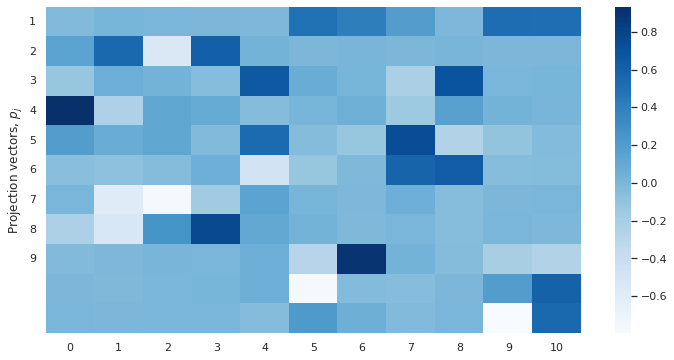

In [ ]:
# # # the correlation between the PC features and the raw features
# rel= pd.DataFrame(pca.components_,df6.columns[0:-3])
# fig, ax = plt.subplots(figsize=(12,6))
# sns.heatmap(rel,cmap='Blues')
# ax.set_yticklabels(np.arange(1,10))
# plt.ylabel('Projection vectors, $p_j$')
# plt.show()

In [ ]:
# # # fit a logistic regression model
# logr=LogisticRegression(multi_class='multinomial')
# logr=LogisticRegression(multi_class='ovr')
# logr_model=logr.fit(X_train_tsf,y_train)

In [ ]:
# # # beta_0
# logr_model.intercept_

array([-9.1148336 , -8.89006998, -7.59710245, -5.23259679, -3.53752248,
       -1.76117284, -1.77726072, -0.57102799, -1.52233711, -4.44415207])

In [ ]:
# # # beta_1,...,beta_8
# logr_model.coef_

array([[-2.64161139e+00, -2.15186357e-01, -3.70861247e-01,
        -7.25698856e-02,  7.15732801e-03, -1.19420973e+00,
         7.05646698e-02, -7.14959003e-02,  4.90952261e-01,
         4.28724347e-02,  1.60171389e+00],
       [-1.66663754e+00,  2.80873557e-01, -2.61089417e-02,
        -3.04805790e-01, -5.47752969e-01, -9.66729361e-01,
        -3.93694871e-02,  4.38484343e-03,  2.39430414e-01,
         3.97710501e-01,  4.93979616e-01],
       [-1.60680070e+00,  9.13095749e-03,  3.63955419e-01,
        -1.96743385e-02,  3.53464292e-01, -2.48263057e-01,
        -5.99041329e-02,  1.43374733e-01,  6.16656488e-01,
        -1.65016175e+00,  1.82002450e+00],
       [-6.48512746e-01,  1.78579667e-02,  2.89722460e-01,
         5.46440761e-02,  1.25312578e-02, -3.10573276e-01,
         6.11684263e-04,  1.52146639e-02,  4.06938689e-01,
        -6.90491813e-01,  5.80556973e-01],
       [-7.45094617e-02,  1.97897355e-02,  4.22044825e-01,
        -5.00647527e-02,  2.29958332e-01, -2.42123522e-01,
  

In [ ]:
# # # testing accuracy
# logr_model.score(X_test_tsf,y_test)

0.4192500738116327

In [ ]:
# # # prediction on training dataset
# y_train_pred = logr_model.predict(X_train_tsf)
# p_train_pred = logr_model.predict_proba(X_train_tsf)

In [ ]:
# # # prediction on testing dataset
# y_test_pred = logr_model.predict(X_test_tsf)
# p_test_pred = logr_model.predict_proba(X_test_tsf)

In [ ]:
# # # classes
# logr_model.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
# [p_0, p_1] # if y_test_pred[i]=1 if p_1>p_2, otherwise y_test_pred[i]=0
logr_model.predict_proba(X_test_tsf)

array([[9.32271958e-08, 1.14392829e-06, 2.89351624e-05, ...,
        2.94434726e-01, 2.71449837e-01, 6.27344459e-03],
       [2.30071387e-02, 1.07840016e-02, 1.11940175e-02, ...,
        4.18785571e-01, 2.03946839e-01, 1.12085738e-01],
       [1.89301760e-10, 1.91196175e-07, 1.30404659e-09, ...,
        2.42851164e-01, 4.80835043e-01, 1.58651301e-02],
       ...,
       [1.21363005e-02, 1.84025711e-03, 4.21319810e-03, ...,
        4.26930860e-01, 2.33929988e-01, 6.75902579e-02],
       [4.40038447e-03, 2.65927522e-03, 4.75045435e-03, ...,
        4.64480825e-01, 1.84974146e-01, 2.96805171e-02],
       [5.04233981e-03, 5.97521657e-03, 4.71489035e-03, ...,
        3.30159782e-01, 2.83268416e-02, 4.17670922e-05]])

In [ ]:
# # confusion matrix
# cnf_matrix=metrics.confusion_matrix(y_test, y_test_pred)

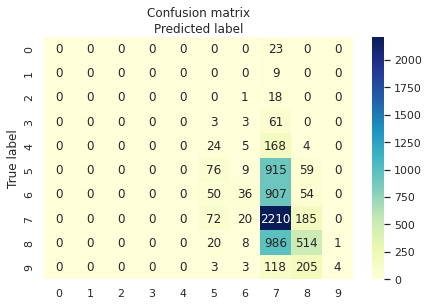

In [ ]:
# # # visualize confusion matrix
# class_names=[0,1] # name  of classes
# fig, ax = plt.subplots()
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names)
# plt.yticks(tick_marks, class_names)
# # # create heatmap
# sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
# ax.xaxis.set_label_position("top")
# plt.tight_layout()
# plt.title('Confusion matrix', y=1.1)
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

Overall, regression with PCA does not make sense, we should typically use PCA when our features or our input variables are hghly correlted with one or more features in our dataset. We do not have a need to do PCA

In [ ]:
# from sklearn.linear_model import LinearRegression
# X_train, X_test, y_train, y_test = train_test_split(X.values, y1.values, test_size = 0.2, random_state=42)
# lr=LinearRegression().fit(X_train,y_train)
# lr

LinearRegression()

In [ ]:
# pred = lr.predict(X_test)
# pred

array([6.65567809, 6.96667078, 7.40497186, ..., 6.87755436, 6.71686116,
       5.37334868])

In [ ]:
# from sklearn.metrics import r2_score
# r2_score(y_test, pred)

0.14232465839248398

In [ ]:
# # # evaluate the goodness-of-fit of the regression model in training using cross-validation
# r2_train = cross_val_score(lr, X_train_tsf, y_train, cv =5, scoring = 'r2').mean()
# print(f'the average r-square value is {r2_train*100 :.2f}%')

the average r-square value is 16.46%


In [ ]:
# # # fit the linear regression model
# lr_model = lr.fit(X_train_tsf,y_train)

In [ ]:
# # # intercept, b_0
# print(f'The intercept is {lr_model.intercept_:.3f}')

The intercept is 6.656


Linear Regression is a bad idea, our R_squared Value is 16.46% correlation between our data

Try Lasso Regression

In [ ]:
# from sklearn.linear_model import Lasso
# X_train, X_test, y_train, y_test = train_test_split(X.values, y1.values, test_size = 0.2, random_state=42)
# lr=Lasso().fit(X_train,y_train)
# lr

Lasso()

In [ ]:
# pred = lr.predict(X_test)
# pred

array([6.80423218, 7.05045293, 6.80016668, ..., 7.0168133 , 6.78297745,
       5.67271969])

In [ ]:
# r2_score(y_test, pred)

0.11941783245929694

Results are even worse

Try Ridge Regression

In [ ]:
# from sklearn.linear_model import Ridge
# X_train, X_test, y_train, y_test = train_test_split(X.values, y1.values, test_size = 0.2, random_state=42)
# lr=Ridge().fit(X_train,y_train)
# lr

Ridge()

In [ ]:
# pred = lr.predict(X_test)
# pred

array([6.65567191, 6.96667209, 7.40492356, ..., 6.87755401, 6.71685832,
       5.3733408 ])

In [ ]:
# r2_score(y_test, pred)

0.14232480241031265

Results are equally poor

Try Using Gridsearch which utilizes hyperparamters that are not learnt using estimators. We want to find the best cross-validation score, in our case we will use Ridge

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)
from sklearn.neighbors import KNeighborsClassifier
lr = Ridge()
lr

parameters = {'alpha':[10,100,1000], 'max_iter':[1000,100000]}
reg = GridSearchCV(lr,parameters,scoring='r2',n_jobs=-1, cv=5)
reg.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [10, 100, 1000], 'max_iter': [1000, 100000]},
             scoring='r2')

In [ ]:
reg.best_estimator_

Ridge(alpha=1000, max_iter=1000)

In [ ]:
reg.best_estimator_.coef_

array([-2.18294891e-02, -4.59980049e-03,  1.55607208e-03,  5.56417288e-05,
       -2.65142066e-02, -5.10294331e-02, -8.57895255e-06,  6.17830984e-03,
       -7.17329642e-03,  7.19082944e-02, -1.25634635e-02])

In [ ]:
pred=reg.predict(X_test)
pred

array([6.01453832, 6.5060615 , 6.70310351, ..., 6.28499943, 6.88149664,
       6.46087922])

In [ ]:
r2_score(y_test,pred)

NameError: ignored

In [ ]:
# assembly model evaluation metrics together
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    #return mae, mse, rmse, r2_square
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R Square:', r2_square)
    print('__________________________________')

In [ ]:
print_evaluate(y_test,pred)

MAE: 0.9434608415003014
MSE: 1.522429662669167
RMSE: 1.2338677654713113
R Square: 0.1574853881936933
__________________________________


Inputs dont properly satisfy the output

In [36]:
# Separate the Feature data X from the response data y1,y2,y3
X=df6.iloc[:,:-3] # All columns except for the last 3 columns
y1=df6.iloc[:,-3] #The last column would be our response variable in our case, Deck Condition
y2=df6.iloc[:,-2]  #The last column would be our response variable in our case, SuperStructure Condition
y3=df6.iloc[:,-1]  #The last column would be our response variable in our case, Substructure Condition

Deck

In [37]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier()

# parameters = {'alpha':[10, 100, 1000], 'max_iter':[1000, 10000]}
parameters = {'n_neighbors':[5,10,100, 1000]}

model = GridSearchCV(clf, parameters, scoring='accuracy',n_jobs=-1, cv=5)
model.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 100, 1000]},
             scoring='accuracy')

In [24]:
model.best_estimator_

KNeighborsClassifier()

In [25]:
pred=model.predict(X_test)
pred

array([5., 5., 7., ..., 8., 7., 8.])

In [26]:
from sklearn import metrics

metrics.accuracy_score(y_test, pred)

0.5171242987894892

In [27]:
# Print the accuracy score
print(f'the accuracy score value for the deck is {metrics.accuracy_score(y_test, pred)*100 :.2f}%')

the accuracy score value for the deck is 51.71%


In [28]:
import pickle
filename = 'GBT_Deck_AK.sav'
pickle.dump(model, open(filename,'wb'))

In [29]:
loaded_model = pickle.load(open(filename,'rb'))
result = loaded_model.score(X_test,y_test)
print(result)

0.5171242987894892


In [30]:
#Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.67      0.43      0.53        23
         1.0       0.00      0.00      0.00         9
         2.0       0.25      0.25      0.25        12
         3.0       0.29      0.19      0.23        62
         4.0       0.33      0.34      0.33       235
         5.0       0.43      0.49      0.46      1069
         6.0       0.42      0.38      0.40      1054
         7.0       0.59      0.66      0.62      2477
         8.0       0.56      0.48      0.52      1508
         9.0       0.55      0.32      0.41       325

    accuracy                           0.52      6774
   macro avg       0.41      0.36      0.37      6774
weighted avg       0.52      0.52      0.51      6774

[[  10    0    0    3    1    0    3    6    0    0]
 [   0    0    0    0    0    0    3    6    0    0]
 [   0    0    3    0    1    2    3    2    0    1]
 [   1    0    1   12   10   13    7   17    1    0]
 [   0    1    1    2   79   

In [31]:
KA = []
ivector= []
for i in range(0,150,10): # Age of Bridge
      pred_i = model.predict(np.array([i,2,30000,50,25,15,10,50,40,30,85]).reshape(1,-1))[0]
      KA.append(pred_i)
      ivector.append(i)
      print(i,pred_i)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


ValueError: ignored

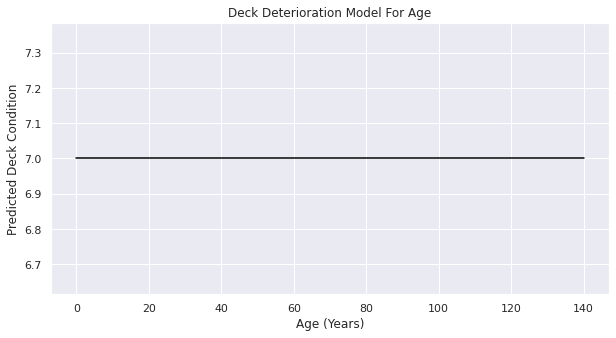

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(ivector, KA, color ='black')
plt.xlabel("Age (Years)")
plt.ylabel("Predicted Deck Condition")
plt.title("Deck Deterioration Model For Age")
plt.show()

In [ ]:
KA1 = []
jvector = []
for j in range(0,500000,5000): # Average Daily Traffic
      pred_j = model.predict(np.array([50,4,j,50,25,15,10,50,40,30,85]).reshape(1,-1))[0]
      KA1.append(pred_j)
      jvector.append(j)
      print(j,pred_j)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature n

0 7.0
5000 7.0
10000 7.0
15000 7.0
20000 7.0
25000 7.0
30000 7.0
35000 7.0
40000 7.0
45000 7.0
50000 7.0
55000 7.0
60000 7.0
65000 7.0
70000 7.0
75000 7.0
80000 7.0
85000 7.0
90000 7.0
95000 7.0
100000 7.0
105000 7.0
110000 7.0
115000 7.0
120000 7.0
125000 7.0
130000 7.0
135000 7.0
140000 7.0
145000 7.0
150000 7.0
155000 7.0
160000 7.0
165000 7.0
170000 7.0
175000 7.0
180000 7.0
185000 7.0
190000 7.0
195000 7.0
200000 7.0
205000 7.0
210000 7.0
215000 7.0
220000 7.0
225000 7.0
230000 7.0
235000 7.0
240000 7.0
245000 7.0
250000 7.0
255000 7.0
260000 7.0
265000 7.0
270000 7.0
275000 7.0
280000 7.0
285000 7.0
290000 7.0
295000 7.0
300000 7.0
305000 7.0
310000 7.0
315000 7.0
320000 7.0
325000 7.0
330000 7.0
335000 7.0
340000 7.0
345000 7.0
350000 7.0
355000 7.0
360000 7.0
365000 7.0
370000 7.0
375000 7.0
380000 7.0
385000 7.0
390000 7.0
395000 7.0
400000 7.0
405000 7.0
410000 7.0
415000 7.0
420000 7.0
425000 7.0
430000 7.0
435000 7.0
440000 7.0
445000 7.0
450000 7.0
455000 7.0
460000 7.0
46

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature n

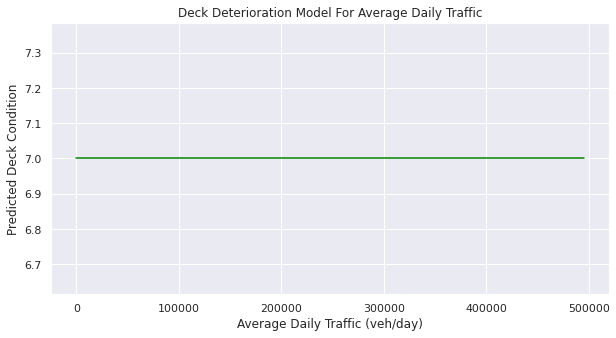

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(jvector, KA1, color ='green')
plt.xlabel("Average Daily Traffic (veh/day)")
plt.ylabel("Predicted Deck Condition")
plt.title("Deck Deterioration Model For Average Daily Traffic")
plt.show()

In [ ]:
KA2 = []
kvector=[]
for k in range(0,55,5): # Average Precipitation
      pred_k = model.predict(np.array([50,2,30000,50,25,15,10,50,k,30,85]).reshape(1,-1))[0]
      KA2.append(pred_k)
      kvector.append(k)
      print(k,pred_k)

0 7.0
5 7.0
10 7.0
15 7.0
20 7.0
25 7.0
30 7.0
35 7.0
40 7.0
45 7.0
50 7.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature n

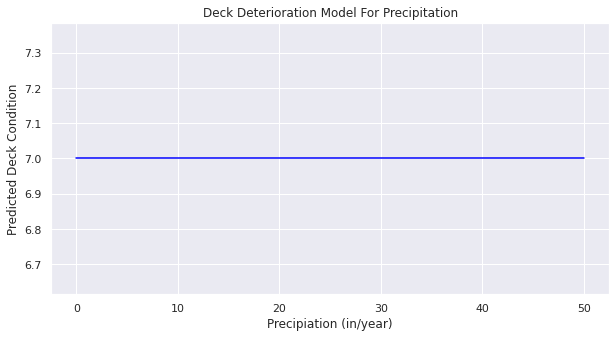

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(kvector, KA2, color ='blue')
plt.xlabel("Precipiation (in/year)")
plt.ylabel("Predicted Deck Condition")
plt.title("Deck Deterioration Model For Precipitation")
plt.show()

In [ ]:
KA3 = []
lvector = []
for l in range(0,95,5): # Average Precipitation
      pred_l = model.predict(np.array([50,2,30000,50,25,15,10,l,40,30,85]).reshape(1,-1))[0]
      KA3.append(pred_l)
      lvector.append(l)
      print(l,pred_l)

0 5.0
5 5.0
10 5.0
15 5.0
20 7.0
25 7.0
30 7.0
35 7.0
40 7.0
45 7.0
50 7.0
55 7.0
60 7.0
65 7.0
70 6.0
75 6.0
80 6.0
85 6.0
90 6.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature n

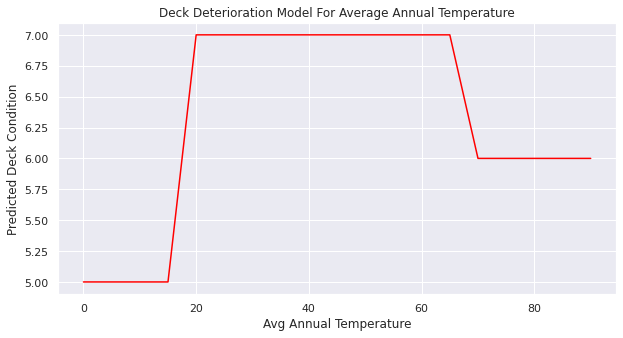

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(lvector, KA3, color ='red')
plt.xlabel("Avg Annual Temperature")
plt.ylabel("Predicted Deck Condition")
plt.title("Deck Deterioration Model For Average Annual Temperature")
plt.show()

For 

In [ ]:
df6.corr()

,avgTemp,avgprcp,min_temp,max_temp,Age_of_Bridge,TRAFFIC_LANES_ON_028A,ADT_029,MAX_SPAN_LEN_MT_048,MAIN_UNIT_SPANS_045,ROADWAY_WIDTH_MT_051,APPR_WIDTH_MT_032,DECK_COND_058,SUPERSTRUCTURE_COND_059,SUBSTRUCTURE_COND_060
avgTemp,1.000000,0.004665,-0.032081,0.134013,-0.008687,-0.034986,-0.013960,-0.010300,-0.008808,-0.026897,-0.030093,-0.025456,-0.031795,-0.021333
avgprcp,0.004665,1.000000,-0.269963,0.358903,0.052827,0.013857,0.019007,0.015650,-0.000223,0.017179,0.026459,-0.027419,-0.035587,-0.035881
min_temp,-0.032081,-0.269963,1.000000,-0.329513,0.004971,0.010518,-0.000371,0.013536,0.001436,0.007422,0.003245,0.042848,0.041701,0.042095
max_temp,0.134013,0.358903,-0.329513,1.000000,-0.013364,0.001457,0.007886,-0.002791,0.002739,0.000530,-0.002606,-0.009463,0.005555,-0.008915
Age_of_Bridge,-0.008687,0.052827,0.004971,-0.013364,1.000000,0.042507,-0.032626,-0.002320,0.150894,-0.052519,-0.016250,-0.351077,-0.351617,-0.381223
TRAFFIC_LANES_ON_028A,-0.034986,0.013857,0.010518,0.001457,0.042507,1.000000,0.577523,0.221524,0.003882,0.871325,0.835122,0.116232,0.136915,0.129547
ADT_029,-0.013960,0.019007,-0.000371,0.007886,-0.032626,0.577523,1.000000,0.188668,0.012054,0.641689,0.600776,0.086596,0.052282,0.067323
MAX_SPAN_LEN_MT_048,-0.010300,0.015650,0.013536,-0.002791,-0.002320,0.221524,0.188668,1.000000,-0.095564,0.244805,0.284855,0.111432,0.083230,0.140290
MAIN_UNIT_SPANS_045,-0.008808,-0.000223,0.001436,0.002739,0.150894,0.003882,0.012054,-0.095564,1.000000,-0.010173,-0.010214,-0.103890,-0.085323,-0.121477
ROADWAY_WIDTH_MT_051,-0.026897,0.017179,0.007422,0.000530,-0.052519,0.871325,0.641689,0.244805,-0.010173,1.000000,0.911316,0.179460,0.187367,0.177165


In [ ]:
import seaborn as sns

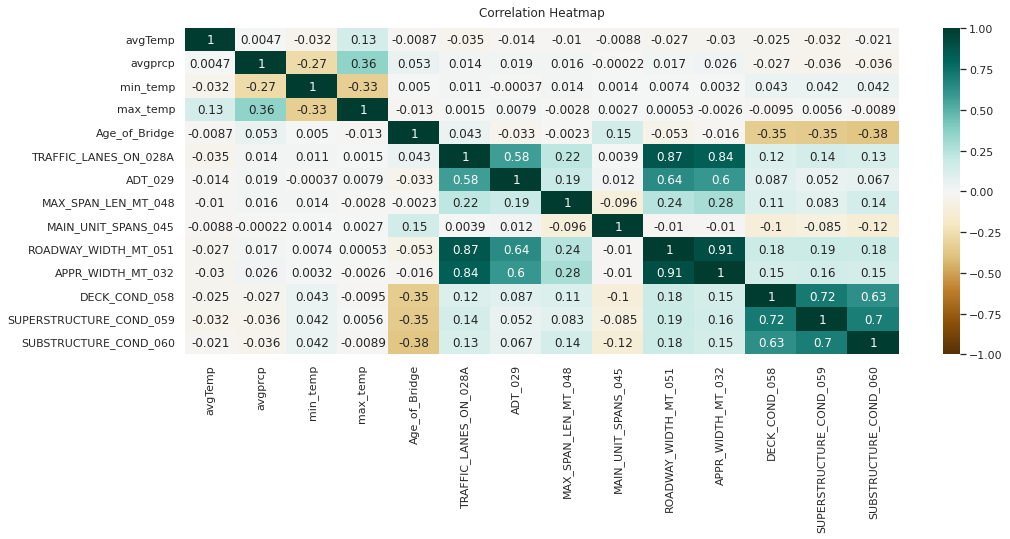

In [ ]:
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(df6.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG');
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Just trying a cool feature

In [ ]:
np.triu(np.ones_like(df6.corr()))

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

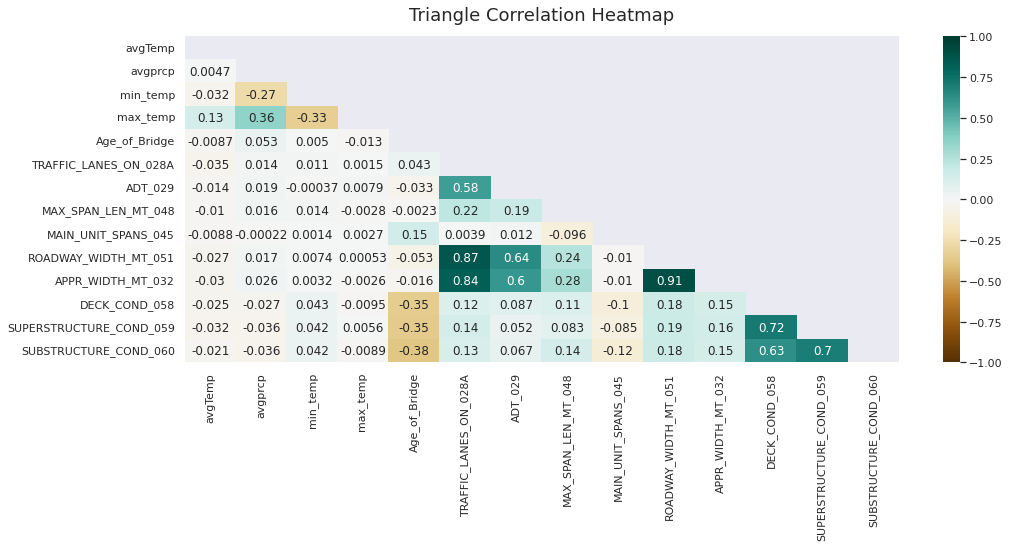

In [ ]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df6.corr(), dtype=np.bool))
heatmap = sns.heatmap(df6.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Try a Polynomial Linear Model

In [ ]:
# # define linear regression model
# lr_model = LinearRegression()

NameError: ignored

In [ ]:
# # evaluate the lR model in training using cross-validation
#print(cross_val_score(lr_model, X_poly_train, y_train, cv =5, scoring = 'r2').mean())

NameError: ignored

In [ ]:
# # fit the polynomial linear model using polynomial features
#plr_model=lr_model.fit(X_poly_train,y_train)

In [ ]:
#y_train_pred = plr_model.predict(X_poly_train)
#print_evaluate(y_train, y_train_pred)

In [ ]:
# # evaluate the model on the testing dataset
#y_test_pred = plr_model.predict(X_poly_test)
#print_evaluate(y_test, y_test_pred)

The result is still not good enough

For the SuperStructure

In [ ]:
# split the dataset into training and testing datasets using a 80%-20% randomized split ##
X1_train, X1_test, y1_train, y1_test = train_test_split(X.values, y2.values, test_size = 0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier()

# parameters = {'alpha':[10, 100, 1000], 'max_iter':[1000, 10000]}
parameters = {'n_neighbors':[5,10,100, 1000]}

model2 = GridSearchCV(clf, parameters, scoring='accuracy',n_jobs=-1, cv=5)
model2.fit(X1_train,y1_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 100, 1000]},
             scoring='accuracy')

In [ ]:
model2.best_estimator_

KNeighborsClassifier()

In [ ]:
pred2=model2.predict(X1_test)
pred2

array([6., 7., 7., ..., 6., 7., 7.])

In [ ]:
print(classification_report(y1_test, pred2))
print(confusion_matrix(y1_test, pred2))

              precision    recall  f1-score   support

         0.0       0.60      0.43      0.50        21
         1.0       0.00      0.00      0.00        12
         2.0       0.25      0.27      0.26        11
         3.0       0.23      0.12      0.16        59
         4.0       0.34      0.34      0.34       134
         5.0       0.45      0.50      0.48      1149
         6.0       0.42      0.40      0.41      1206
         7.0       0.55      0.63      0.58      2333
         8.0       0.56      0.48      0.51      1543
         9.0       0.54      0.31      0.39       306

    accuracy                           0.50      6774
   macro avg       0.39      0.35      0.36      6774
weighted avg       0.50      0.50      0.50      6774

[[   9    0    0    0    3    2    2    5    0    0]
 [   0    0    0    3    0    1    0    6    2    0]
 [   0    0    3    0    2    2    1    1    1    1]
 [   1    1    0    7    1   17   14   16    2    0]
 [   0    0    0    2   45   

In [ ]:
from sklearn import metrics

metrics.accuracy_score(y1_test, pred2)

0.504428697962799

In [ ]:
# Print the accuracy score
print(f'The accuracy score value for the Superstructure is {metrics.accuracy_score(y1_test, pred2)*100 :.2f}%')

The accuracy score value for the Superstructure is 50.44%


In [ ]:
import pickle
filename2 = 'GBT_Super_AK.sav'
pickle.dump(model2, open(filename2,'wb'))

In [ ]:
loaded_model2 = pickle.load(open(filename2,'rb'))
result2 = loaded_model2.score(X1_test,y1_test)
print(result2)

0.504428697962799


In [ ]:
KA4 = []
hvector=[]
for h in range(0,150,10): # Age of Bridge
      pred_h = model2.predict(np.array([h,2,30000,50,25,15,10,50,40,30,85]).reshape(1,-1))[0]
      KA4.append(pred_h)
      hvector.append(h)
      print(h,pred_h)

0 6.0
10 6.0
20 6.0
30 6.0
40 6.0
50 6.0
60 6.0
70 6.0
80 6.0
90 6.0
100 6.0
110 6.0
120 6.0
130 6.0
140 6.0


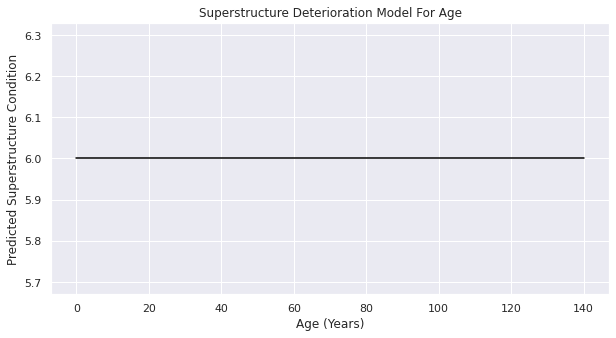

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(hvector, KA4, color ='black')
plt.xlabel("Age (Years)")
plt.ylabel("Predicted Superstructure Condition")
plt.title("Superstructure Deterioration Model For Age")
plt.show()

In [ ]:
KA5 = []
mvector=[]
for m in range(0,500000,5000): # Average Daily Traffic
      pred_m = model2.predict(np.array([50,4,m,50,25,15,10,50,40,30,85]).reshape(1,-1))[0]
      KA5.append(pred_m)
      mvector.append(m)
      print(m,pred_m)

0 7.0
5000 6.0
10000 6.0
15000 6.0
20000 6.0
25000 6.0
30000 6.0
35000 6.0
40000 6.0
45000 6.0
50000 6.0
55000 6.0
60000 6.0
65000 6.0
70000 6.0
75000 6.0
80000 6.0
85000 6.0
90000 6.0
95000 6.0
100000 6.0
105000 6.0
110000 6.0
115000 6.0
120000 6.0
125000 6.0
130000 6.0
135000 6.0
140000 6.0
145000 6.0
150000 6.0
155000 6.0
160000 6.0
165000 6.0
170000 6.0
175000 6.0
180000 6.0
185000 6.0
190000 6.0
195000 6.0
200000 6.0
205000 6.0
210000 6.0
215000 6.0
220000 6.0
225000 6.0
230000 6.0
235000 6.0
240000 6.0
245000 6.0
250000 6.0
255000 6.0
260000 6.0
265000 6.0
270000 6.0
275000 6.0
280000 6.0
285000 6.0
290000 6.0
295000 6.0
300000 6.0
305000 6.0
310000 6.0
315000 6.0
320000 6.0
325000 6.0
330000 6.0
335000 6.0
340000 6.0
345000 6.0
350000 6.0
355000 6.0
360000 6.0
365000 6.0
370000 6.0
375000 6.0
380000 6.0
385000 6.0
390000 6.0
395000 6.0
400000 6.0
405000 6.0
410000 6.0
415000 6.0
420000 6.0
425000 6.0
430000 6.0
435000 6.0
440000 6.0
445000 6.0
450000 6.0
455000 6.0
460000 6.0
46

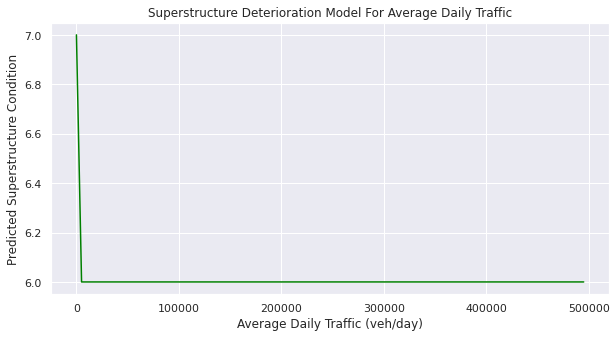

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(mvector, KA5, color ='green')
plt.xlabel("Average Daily Traffic (veh/day)")
plt.ylabel("Predicted Superstructure Condition")
plt.title("Superstructure Deterioration Model For Average Daily Traffic")
plt.show()

In [ ]:
KA6 = []
nvector=[]
for n in range(0,50,5): # Average Precipitation
      pred_n = model2.predict(np.array([50,2,30000,50,25,15,10,50,n,30,85]).reshape(1,-1))[0]
      KA6.append(pred_n)
      nvector.append(n)
      print(n,pred_n)

0 6.0
5 6.0
10 6.0
15 6.0
20 6.0
25 6.0
30 6.0
35 6.0
40 6.0
45 6.0


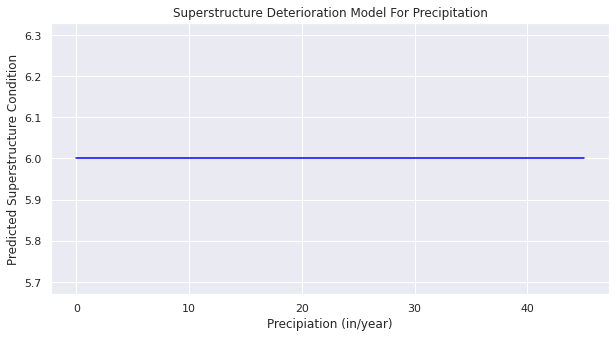

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(nvector, KA6, color ='blue')
plt.xlabel("Precipiation (in/year)")
plt.ylabel("Predicted Superstructure Condition")
plt.title("Superstructure Deterioration Model For Precipitation")
plt.show()

In [ ]:
KA7 = []
tvector=[]
for t in range(0,95,5): # Average Temperature
      pred_t = model2.predict(np.array([50,2,30000,50,25,15,10,t,40,30,85]).reshape(1,-1))[0]
      KA7.append(pred_t)
      tvector.append(t)
      print(t,pred_t)

0 5.0
5 5.0
10 5.0
15 5.0
20 5.0
25 5.0
30 7.0
35 7.0
40 7.0
45 6.0
50 6.0
55 6.0
60 6.0
65 7.0
70 9.0
75 9.0
80 9.0
85 9.0
90 9.0


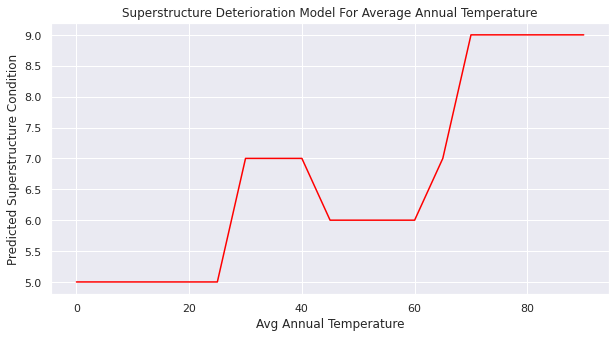

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(tvector, KA7, color ='red')
plt.xlabel("Avg Annual Temperature")
plt.ylabel("Predicted Superstructure Condition")
plt.title("Superstructure Deterioration Model For Average Annual Temperature")
plt.show()

Third Model-Substructure

In [ ]:
# split the dataset into training and testing datasets using a 80%-20% randomized split ##
X2_train, X2_test, y2_train, y2_test = train_test_split(X.values, y3.values, test_size = 0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
clf=KNeighborsClassifier()

# parameters = {'alpha':[10, 100, 1000], 'max_iter':[1000, 10000]}
parameters = {'n_neighbors':[5,10,100, 1000]}

model3 = GridSearchCV(clf, parameters, scoring='accuracy',n_jobs=-1, cv=5)
model3.fit(X2_train,y2_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 100, 1000]},
             scoring='accuracy')

In [ ]:
model3.best_estimator_

KNeighborsClassifier()

In [ ]:
pred3=model3.predict(X2_test)
pred3

array([5., 5., 7., ..., 8., 6., 7.])

In [ ]:
print(classification_report(y2_test, pred3))
print(confusion_matrix(y2_test, pred3))

              precision    recall  f1-score   support

         0.0       0.54      0.46      0.50        28
         1.0       0.00      0.00      0.00         6
         2.0       0.19      0.13      0.16        45
         3.0       0.30      0.28      0.29       118
         4.0       0.28      0.24      0.26       307
         5.0       0.44      0.51      0.47      1233
         6.0       0.41      0.39      0.40      1196
         7.0       0.54      0.60      0.57      2155
         8.0       0.55      0.48      0.51      1408
         9.0       0.56      0.32      0.41       278

    accuracy                           0.48      6774
   macro avg       0.38      0.34      0.36      6774
weighted avg       0.48      0.48      0.48      6774

[[  13    0    0    1    1    3    4    5    1    0]
 [   0    0    0    0    1    0    1    4    0    0]
 [   2    0    6    6    7    8    4   12    0    0]
 [   1    0    0   33   15   32    9   20    8    0]
 [   1    0    5   13   73   

In [ ]:
from sklearn import metrics

metrics.accuracy_score(y2_test, pred3)

0.48287570121051077

In [ ]:
# Print the accuracy score
print(f'the accuracy score value for the Sub-Structure is {metrics.accuracy_score(y2_test, pred3)*100 :.2f}%')

the accuracy score value for the Sub-Structure is 48.29%


In [ ]:
import pickle
filename3 = 'GBT_Sub_AK.sav'
pickle.dump(model3, open(filename,'wb'))

In [ ]:
loaded_model = pickle.load(open(filename3,'rb'))
result3 = loaded_model3.score(X2_test,y2_test)
print(result3)

FileNotFoundError: ignored

In [ ]:
KA8 = []
uvector = []
for u in range(0,150,10): # Age of Bridge
      pred_u = model3.predict(np.array([u,2,30000,50,25,15,10,50,40,30,85]).reshape(1,-1))[0]
      KA8.append(pred_u)
      uvector.append(u)
      print(u,pred_u)

0 7.0
10 7.0
20 7.0
30 7.0
40 7.0
50 7.0
60 7.0
70 7.0
80 7.0
90 7.0
100 7.0
110 7.0
120 7.0
130 7.0
140 7.0


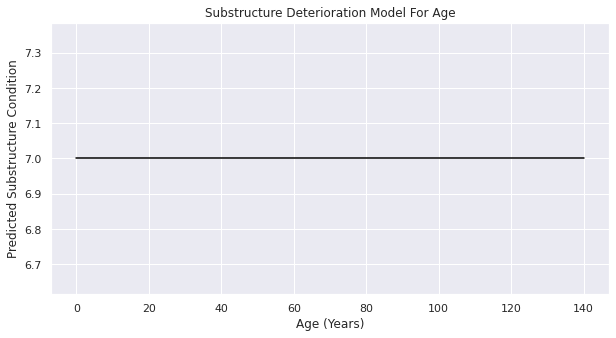

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(uvector, KA8, color ='black')
plt.xlabel("Age (Years)")
plt.ylabel("Predicted Substructure Condition")
plt.title("Substructure Deterioration Model For Age")
plt.show()

In [ ]:
KA9 = []
yvector=[]
for y in range(0,500000,5000): # Average Daily Traffic
      pred_y = model3.predict(np.array([50,4,y,50,25,15,10,50,40,30,85]).reshape(1,-1))[0]
      KA9.append(pred_y)
      yvector.append(y)
      print(y,pred_y)

0 7.0
5000 7.0
10000 7.0
15000 7.0
20000 7.0
25000 7.0
30000 7.0
35000 7.0
40000 7.0
45000 7.0
50000 7.0
55000 7.0
60000 7.0
65000 7.0
70000 7.0
75000 7.0
80000 7.0
85000 7.0
90000 7.0
95000 7.0
100000 7.0
105000 7.0
110000 7.0
115000 7.0
120000 7.0
125000 7.0
130000 7.0
135000 7.0
140000 7.0
145000 7.0
150000 7.0
155000 7.0
160000 7.0
165000 7.0
170000 7.0
175000 7.0
180000 7.0
185000 7.0
190000 7.0
195000 7.0
200000 7.0
205000 7.0
210000 7.0
215000 7.0
220000 7.0
225000 7.0
230000 7.0
235000 7.0
240000 7.0
245000 7.0
250000 7.0
255000 7.0
260000 7.0
265000 7.0
270000 7.0
275000 7.0
280000 7.0
285000 7.0
290000 7.0
295000 7.0
300000 7.0
305000 7.0
310000 7.0
315000 7.0
320000 7.0
325000 7.0
330000 7.0
335000 7.0
340000 7.0
345000 7.0
350000 7.0
355000 7.0
360000 7.0
365000 7.0
370000 7.0
375000 7.0
380000 7.0
385000 7.0
390000 7.0
395000 7.0
400000 7.0
405000 7.0
410000 7.0
415000 7.0
420000 7.0
425000 7.0
430000 7.0
435000 7.0
440000 7.0
445000 7.0
450000 7.0
455000 7.0
460000 7.0
46

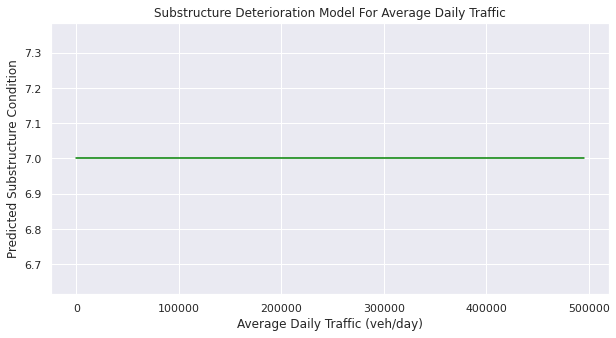

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(yvector, KA9, color ='green')
plt.xlabel("Average Daily Traffic (veh/day)")
plt.ylabel("Predicted Substructure Condition")
plt.title("Substructure Deterioration Model For Average Daily Traffic")
plt.show()

In [ ]:
KA10 = []
xvector=[]
for x in range(0,50,5): # Average Precipitation
      pred_x = model3.predict(np.array([50,2,30000,50,25,15,10,50,x,30,85]).reshape(1,-1))[0]
      KA10.append(pred_x)
      xvector.append(x)
      print(x,pred_x)

0 7.0
5 7.0
10 7.0
15 7.0
20 7.0
25 7.0
30 7.0
35 7.0
40 7.0
45 7.0


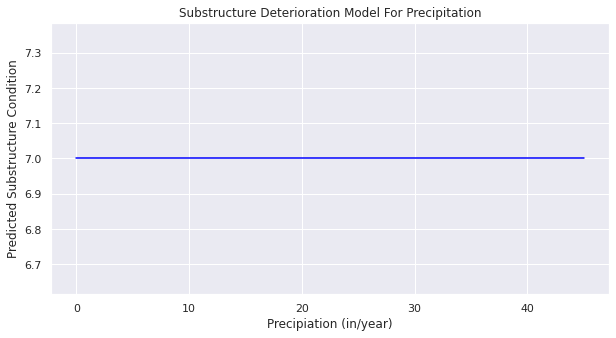

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(xvector, KA10, color ='blue')
plt.xlabel("Precipiation (in/year)")
plt.ylabel("Predicted Substructure Condition")
plt.title("Substructure Deterioration Model For Precipitation")
plt.show()

In [ ]:
KA11 = []
zvector=[]
for z in range(0,95,5): # Average Temperature
      pred_z = model3.predict(np.array([50,2,30000,50,25,15,10,z,40,30,85]).reshape(1,-1))[0]
      KA11.append(pred_z)
      zvector.append(z)
      print(z,pred_z)

0 5.0
5 5.0
10 5.0
15 5.0
20 7.0
25 7.0
30 7.0
35 7.0
40 7.0
45 7.0
50 7.0
55 7.0
60 7.0
65 7.0
70 9.0
75 9.0
80 9.0
85 9.0
90 9.0


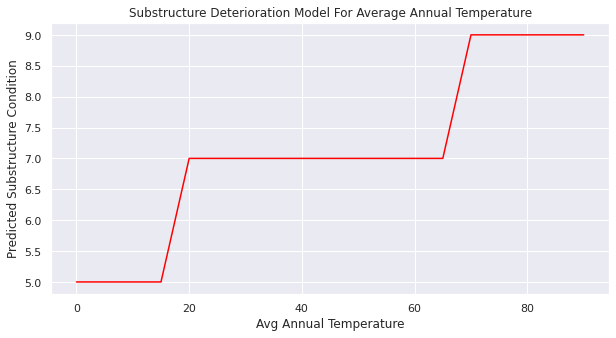

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(zvector, KA11, color ='red')
plt.xlabel("Avg Annual Temperature")
plt.ylabel("Predicted Substructure Condition")
plt.title("Substructure Deterioration Model For Average Annual Temperature")
plt.show()

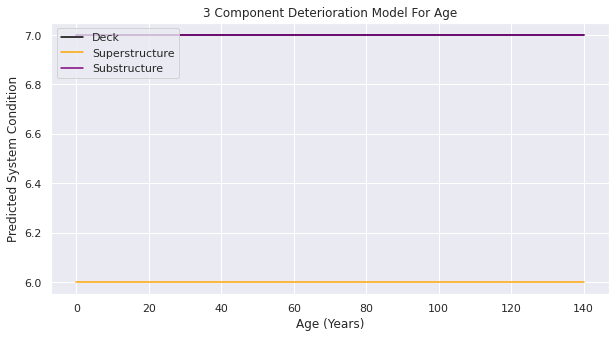

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(ivector, KA, color ='black',label = "Deck")
plt.plot(hvector, KA4, color ='orange',label = "Superstructure")
plt.plot(uvector, KA8, color ='purple', label = "Substructure")
plt.legend(loc="upper left")
plt.xlabel("Age (Years)")
plt.ylabel("Predicted System Condition")
plt.title("3 Component Deterioration Model For Age")
plt.show()

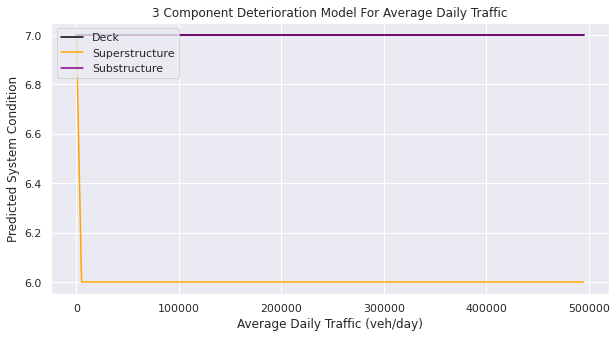

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(jvector, KA1, color ='black',label = "Deck")
plt.plot(mvector, KA5, color ='orange',label = "Superstructure")
plt.plot(yvector, KA9, color ='purple', label = "Substructure")
plt.legend(loc="upper left")
plt.xlabel("Average Daily Traffic (veh/day)")
plt.ylabel("Predicted System Condition")
plt.title("3 Component Deterioration Model For Average Daily Traffic")
plt.show()

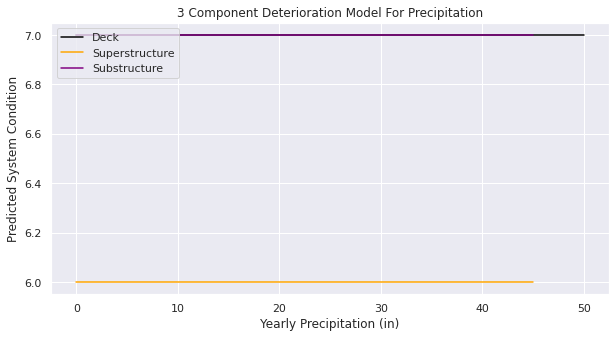

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(kvector, KA2, color ='black',label = "Deck")
plt.plot(nvector, KA6, color ='orange',label = "Superstructure")
plt.plot(xvector, KA10, color ='purple', label = "Substructure")
plt.legend(loc="upper left")
plt.xlabel("Yearly Precipitation (in)")
plt.ylabel("Predicted System Condition")
plt.title("3 Component Deterioration Model For Precipitation")
plt.show()

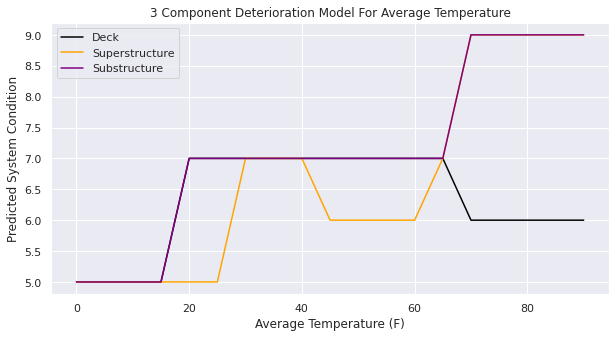

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.plot(lvector, KA3, color ='black',label = "Deck")
plt.plot(tvector, KA7, color ='orange',label = "Superstructure")
plt.plot(zvector, KA11, color ='purple', label = "Substructure")
plt.legend(loc="upper left")
plt.xlabel("Average Temperature (F)")
plt.ylabel("Predicted System Condition")
plt.title("3 Component Deterioration Model For Average Temperature")
plt.show()

Try Gradient Boosting Trees

We dont need to use gradient boosting trees since the K-Nearest Neighbors produces more accurate results with lower time to run

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0, max_depth=1, random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

0.4552701505757307

K-Neghbors has more accurate results

Try Support Vector Machines

In [ ]:
from sklearn import svm
regr = svm.SVR()
regr.fit(X_train, y_train)
regr.score(X_test,y_test)

-0.014240524984426628

In [ ]:
clf = svm.SVC(decision_function_shape='ovo')

In [ ]:
clf.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

In [ ]:
clf.score(X_test,y_test)

0.3860348390906407

K-Neighbors has more accurate results

**Visualization of Current Deck and Superstructure Materials** 

In [ ]:
#Visualizing current deck structure parameters
#Deck structure type is 106,wearing surface is 107,membrane type is 108,deck protection is 109
Vis=pd.read_csv("Datafor555/AK/AK20.csv")
Vis.iloc[:,106]



0       3
1       3
2       5
3       3
4       3
       ..
1640    8
1641    8
1642    8
1643    6
1644    2
Name: DECK_STRUCTURE_TYPE_107, Length: 1645, dtype: object

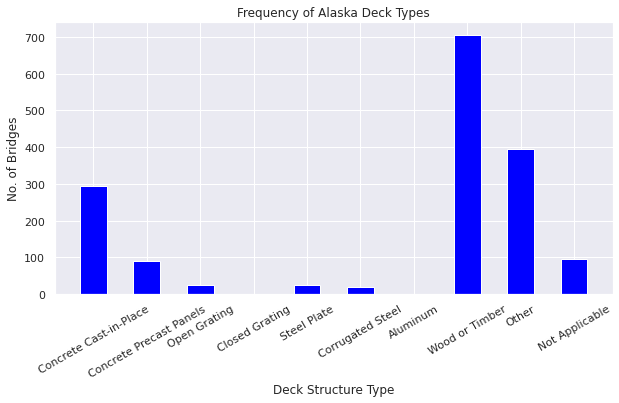

In [ ]:
#Vis['DECK_STRUCTURE_TYPE_107'].value_counts()
# 1 Concrete Cast-in-Place 2 Concrete Precast Panels 3 Open Grating 4 Closed Grating 5 Steel plate 6 Corrugated Steel 7 Aluminum 8 Wood or Timber 9 Other N Not applicable
data_dict = {'Concrete Cast-in-Place':293, 'Concrete Precast Panels':89, 'Open Grating':25, 'Closed Grating':1,'Steel Plate':24,'Corrugated Steel':18,'Aluminum':0,'Wood or Timber':705,'Other':394,'Not Applicable':96}
types = list(data_dict.keys())
values = list(data_dict.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(types, values, color ='blue',
        width = 0.5)
plt.xlabel("Deck Structure Type")
plt.xticks(rotation=30)
plt.ylabel("No. of Bridges")
plt.title("Frequency of Alaska Deck Types")
plt.show()

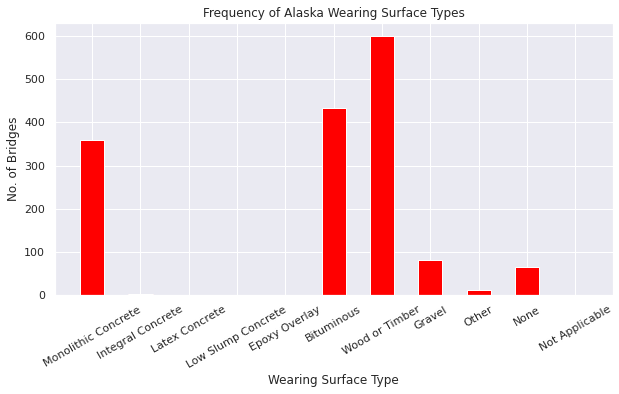

In [ ]:
#Vis['SURFACE_TYPE_108A'].value_counts()
#1 Monolithic Concrete 2 Integral Concrete 3 Latex Concrete 4 Low Slump Concrete 5 Epoxy Overlay 6 Bituminous 7 Wood or Timber 8 Gravel 9 Other 0 None (no additional concrete thickness or N Not Applicable (applies only to structures
data_dict = {'Monolithic Concrete':359, 'Integral Concrete':2, 'Latex Concrete':0, 'Low Slump Concrete':0,'Epoxy Overlay':0,'Bituminous':433,'Wood or Timber':600,'Gravel':82,'Other':11, 'None':64,'Not Applicable':0}
types = list(data_dict.keys())
values = list(data_dict.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(types, values, color ='red',
        width = 0.5)
plt.xlabel("Wearing Surface Type")
plt.xticks(rotation=30)
plt.ylabel("No. of Bridges")
plt.title("Frequency of Alaska Wearing Surface Types")
plt.show()

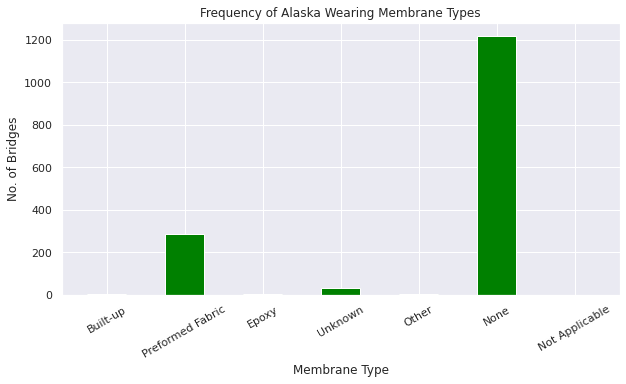

In [ ]:
#Vis['MEMBRANE_TYPE_108B'].value_counts()
# 1 Built-up 2 Preformed Fabric 3 Epoxy 8 Unknown 9 Other 0 None N Not Applicable 
data_dict = {'Built-up':3, 'Preformed Fabric':284, 'Epoxy':5, 'Unknown':30,'Other':5,'None':1219,'Not Applicable':0}
types = list(data_dict.keys())
values = list(data_dict.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(types, values, color ='green',
        width = 0.5)
plt.xlabel("Membrane Type")
plt.xticks(rotation=30)
plt.ylabel("No. of Bridges")
plt.title("Frequency of Alaska Wearing Membrane Types")
plt.show()


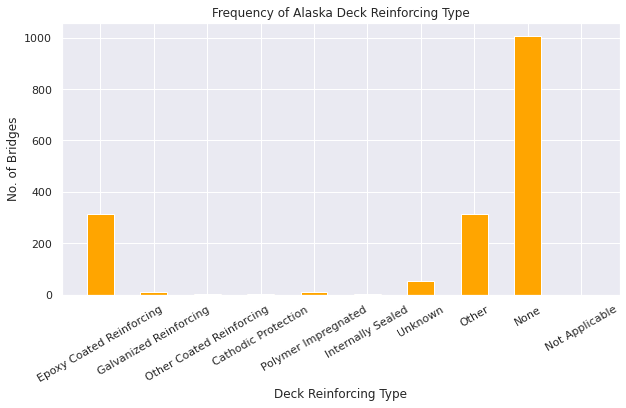

In [ ]:
#Vis['DECK_PROTECTION_108C'].value_counts()
#1 Epoxy Coated Reinforcing 2 Galvanized Reinforcing 3 Other Coated Reinforcing 4 Cathodic Protection 6 Polymer Impregnated 7 Internally Sealed8 Unknown 9 Other 0 None N Not Applicable
data_dict = {'Epoxy Coated Reinforcing':315, 'Galvanized Reinforcing':9, 'Other Coated Reinforcing':1, 'Cathodic Protection':2,'Polymer Impregnated':11,'Internally Sealed':3,'Unknown':54,'Other':315,'None':1008,'Not Applicable':0}
types = list(data_dict.keys())
values = list(data_dict.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(types, values, color ='orange',
        width = 0.5)
plt.xlabel("Deck Reinforcing Type")
plt.xticks(rotation=30)
plt.ylabel("No. of Bridges")
plt.title("Frequency of Alaska Deck Reinforcing Type")
plt.show()

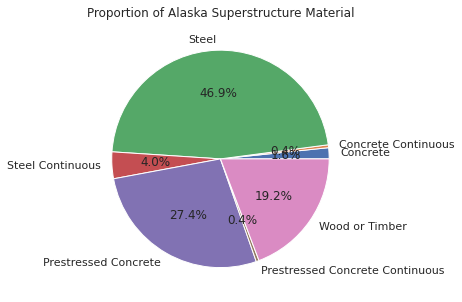

In [ ]:
#Superstructure material Material is 47, structure type is 48
import matplotlib.pyplot as plt
#Vis['STRUCTURE_KIND_043A'].value_counts()
#1 Concrete 2 Concrete continuous 3 Steel 4 Steel continuous 5 Prestressed concrete * 6 Prestressed concrete continuous * 7 Wood or Timber 8 Masonry 9 Aluminum, Wrought Iron, or Cast Iron 0 Other
data_dict={'Concrete':27,'Concrete Continuous':7,'Steel':768,'Steel Continuous':65,'Prestressed Concrete':449,'Prestressed Concrete Continuous':7,'Wood or Timber':315}
types = list(data_dict.keys())
values = list(data_dict.values())
fig = plt.figure(figsize = (10, 5))
plt.pie(values, labels=types,autopct='%1.1f%%')
plt.title("Proportion of Alaska Superstructure Material")
plt.show()